In [1]:
# necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import nibabel as nib
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, 
                                     Conv2DTranspose, Concatenate, Dropout)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
tf.__version__

'2.4.1'

In [2]:
START_AT = 22
NUM_SLICES = 100
IMG_SIZE = 128

CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

In [3]:
FILES = sorted(tf.io.gfile.glob("/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*"))[:-2]

In [4]:
FILES.pop(354) # ill formated (as per Kaggle)

'/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355'

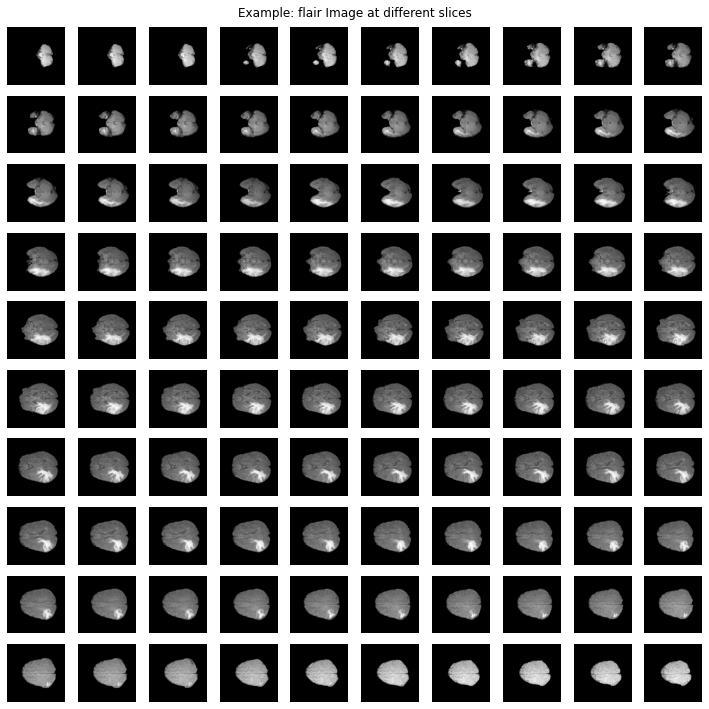

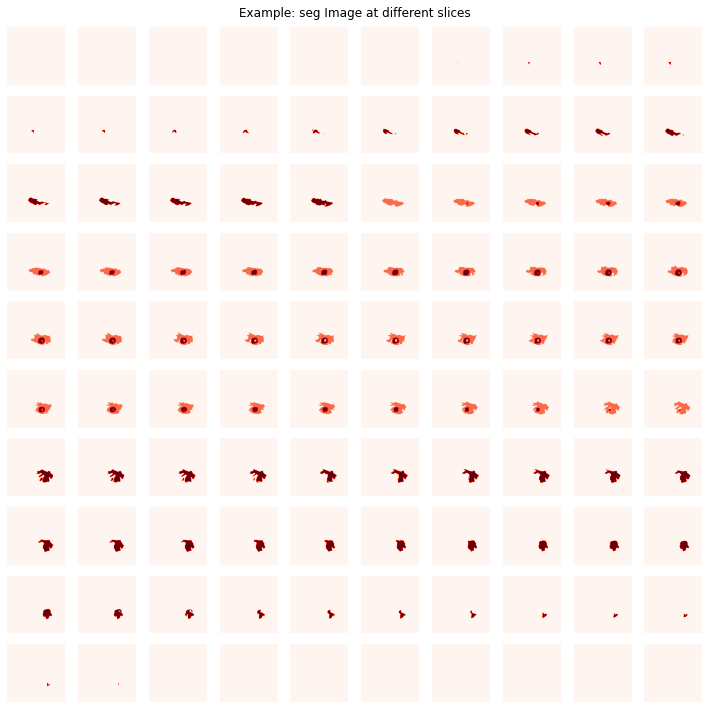

In [5]:
# DATA VISUALAIZATION

let = np.random.choice(FILES)
for scan in ["flair", "seg"]:
    img =  nib.load(tf.io.gfile.glob(let+"/"+f"*{scan}.nii")[0]).get_fdata()[..., START_AT:START_AT+NUM_SLICES]
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    count, i, j = 0, 0, 0
    while count<NUM_SLICES:
        ax[i, j].imshow(img[..., count], cmap=("gray" if scan=="flair" else "Reds"))
        ax[i, j].axis(False)
        j+=1
        if j==10:
            i+=1
            j=0
        count+=1
    fig.suptitle(f"Example: {scan} Image at different slices")
    plt.tight_layout()
    plt.plot()

# Model

In [6]:
def U_net2d(input_shape, classes):
    
    conv = partial(Conv2D, kernel_size=3, 
                   activation='relu', padding='same')
    convT = partial(Conv2DTranspose, kernel_size=2, 
                    strides=2, padding='same', activation='relu')
    x = inputs = Input(shape=input_shape)
   
    # encoder part:
    x = conv(64)(x)
    x = x1 = conv(64)(x)
    x = MaxPool2D(pool_size=2)(x)

    x = conv(128)(x)
    x = x2 = conv(128)(x)
    x = MaxPool2D(pool_size=2)(x)

    x = conv(256)(x)
    x = x3 = conv(256)(x)
    x = MaxPool2D(pool_size=2)(x)

    x = conv(512)(x)
    x = x4 = conv(512)(x)
    x = MaxPool2D(pool_size=2)(x)

    x = conv(1024)(x)
    x = conv(1024)(x)
    x = Dropout(0.1)(x)

    # decoder part:
    x = convT(512)(x)
    x = Concatenate(axis=-1)([x4, x])
    x = conv(512)(x)
    x = conv(512)(x)

    x = convT(256)(x)
    x = Concatenate(axis=-1)([x3, x])
    x = conv(256)(x)
    x = conv(256)(x)

    x = convT(128)(x)
    x = Concatenate(axis=-1)([x2, x])
    x = conv(128)(x)
    x = conv(128)(x)

    x = convT(64)(x)
    x = Concatenate(axis=-1)([x1, x])
    x = conv(64)(x)
    x = conv(64)(x)

    x = outputs = Conv2D(classes, kernel_size=1, activation='softmax')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name='2D-U-NET')


model = U_net2d(input_shape=(IMG_SIZE, IMG_SIZE, 2), classes=len(CLASSES))
model.summary()

In [7]:
# Metrics:

def dice_coefficient(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
    dice_per_class = (2.0 * intersection + smooth) / (union + smooth)
    average_dice = tf.reduce_mean(dice_per_class)
    return average_dice

def precision(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    true_positives = tf.reduce_sum(y_true * y_pred, axis=axis)
    false_positives = tf.reduce_sum(y_pred, axis=axis) - true_positives
    precision_per_class = true_positives / (true_positives + false_positives + smooth)
    average_precision = tf.reduce_mean(precision_per_class)
    return average_precision

def sensitivity(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    true_positives = tf.reduce_sum(y_true * y_pred, axis=axis)
    false_negatives = tf.reduce_sum(y_true, axis=axis) - true_positives
    recall_per_class = true_positives / (true_positives + false_negatives + smooth)
    average_recall = tf.reduce_mean(recall_per_class)
    return average_recall

In [25]:
# model = tf.keras.models.load_model(
#     "/kaggle/input/weights/weights/unet_brats.h5", 
#     custom_objects= {
#         "dice_coefficient": dice_coefficient,
#         "precision": precision,
#         "sensitivity": sensitivity,
#     }
# )
# model.summary()

In [9]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy', tf.keras.metrics.MeanIoU(len(CLASSES)), 
             dice_coefficient, precision, sensitivity]
)

# Data Preprocessing

In [10]:
class BratsDataset(tf.keras.utils.Sequence):
    
    def __init__(self, files):
        self.files = files
        self.on_epoch_end()
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        
        filepath = self.files[idx]

        flair = tf.io.gfile.glob(filepath + "/" + "*flair.nii").pop()
        t1ce = tf.io.gfile.glob(filepath + "/" +"*t1ce.nii").pop()
        seg = tf.io.gfile.glob(filepath + "/" +"*seg.nii").pop() 

        flair = nib.load(flair).get_fdata()[..., START_AT:START_AT+NUM_SLICES]
        t1ce = nib.load(t1ce).get_fdata()[..., START_AT:START_AT+NUM_SLICES]
        seg = nib.load(seg).get_fdata()[..., START_AT:START_AT+NUM_SLICES]
        seg[seg==4] = 3

        seg = tf.convert_to_tensor(seg, dtype=tf.uint8)
        flair = tf.convert_to_tensor(flair)
        t1ce = tf.convert_to_tensor(t1ce)

        seg = tf.transpose(seg, [2, 0, 1])
        flair = tf.transpose(flair, [2, 0, 1])
        t1ce = tf.transpose(t1ce, [2, 0, 1])

        X = tf.concat([
            tf.expand_dims(flair, -1),
            tf.expand_dims(t1ce, -1)
        ], axis=-1)
        
        X = tf.image.resize(X, (IMG_SIZE, IMG_SIZE))
        X = X/(tf.reduce_max(X))

        y = tf.one_hot(seg, len(CLASSES))
        y = tf.image.resize(y, (IMG_SIZE, IMG_SIZE), method='nearest')

        
        return X, y
    
    def on_epoch_end(self):
        np.random.shuffle(self.files)

In [11]:
trainfiles, testfiles = train_test_split(FILES, test_size=0.1, random_state=2205)
trainfiles, valfiles = train_test_split(trainfiles, test_size=0.1, random_state=57)
len(trainfiles), len(valfiles), len(testfiles)

(297, 34, 37)

In [12]:
trainloader = BratsDataset(files=trainfiles)
valloader = BratsDataset(files=valfiles)
testloader = BratsDataset(files=testfiles)

# Training

In [13]:
callbackks = [ModelCheckpoint("2dunet_weights.h5", save_best_only=True),
              EarlyStopping(patience=5, verbose=1)]

In [14]:
history = model.fit(trainloader, epochs=50, validation_data=valloader, callbacks=callbackks)

In [15]:
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Cross-entropy loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Cross-entropy loss")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Val accuracy")
plt.plot(history.history["mean_io_u"], label="Train MeanIOU")
plt.plot(history.history["val_mean_io_u"], label="Val MeanIOU")
plt.title("Accuracy vs epochs and MeanIOU vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy/MeanIOU")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
plt.plot(history.history["dice_coefficient"], label="Train dice coefficient")
plt.plot(history.history["val_dice_coefficient"], label="Val dice coefficient")
plt.plot(history.history["precision"], label="Train precision")
plt.plot(history.history["val_precision"], label="Val precision")
plt.plot(history.history["sensitivity"], label="Train sensitivity")
plt.plot(history.history["val_sensitivity"], label="Val sensitivity")
plt.title("Trend of Dice coefficient, Precision and sensitivity with no. of epochs")
plt.xlabel("Epochs")
plt.ylabel("Dice coefficient / Precision / sensitivity")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation

In [18]:
test_metrics = model.evaluate(testloader)
val_metrics = model.evaluate(valloader)
train_metrics = model.evaluate(trainloader)

297/297 [==============================] - 232s 782ms/step - loss: 0.0112 - accuracy: 0.9958 - mean_io_u: 0.8743 - dice_coefficient: 0.4621 - precision: 0.4645 - sensitivity: 0.4677


In [19]:
pd.DataFrame(np.array([test_metrics, val_metrics, train_metrics]).T,
             index= ["Cross-Entropy Loss", "Accuracy", "Mean IoU", 
                     "Dice Coefficient", "Precision", "Sensitivity"], 
             columns=["on testset", "on valset", "on trainset"])

,on testset,on valset,on trainset
Cross-Entropy Loss,0.015792,0.017722,0.011198
Accuracy,0.995261,0.994443,0.995751
Mean IoU,0.865416,0.878487,0.874282
Dice Coefficient,0.420108,0.421574,0.462116
Precision,0.435765,0.434001,0.464538
Sensitivity,0.424902,0.428380,0.467717


# Predictions

In [20]:
def verify(idx, loader):
    
    xi, yi = loader[idx]
    yi_pred = model(xi)
    fig, ax = plt.subplots(5, 2, figsize=(15,15))

    ax[0, 0].imshow(xi[50, ..., 0], cmap='gray')
    ax[0, 0].set_title("Flair image")

    ax[0, 1].imshow(xi[50, ..., 1], cmap='gray')
    ax[0, 1].set_title("T1ce image")
    
# overlaying:
#     for i in range(1, 5):
#         for j in range(2):
#             ax[i, j].imshow(xi[50, ..., 0], cmap='OrRd', alpha=0.3)

    ax[1, 0].imshow(tf.argmax(yi, axis=-1)[50], cmap="Reds")
    ax[1, 0].set_title("Ground truth tumor")

    ax[1, 1].imshow(tf.argmax(yi_pred, axis=-1)[50], cmap="Reds")
    ax[1, 1].set_title("Predicted tumor")
    
    for i in range(2, 5):
        
        ax[i, 0].imshow(yi[50, ..., i-1], cmap='gray')
        ax[i, 0].set_title("Ground Truth "+ CLASSES[i-1])
        
        ax[i, 1].imshow(yi_pred[50, ..., i-1], cmap='gray')
        ax[i, 1].set_title("Predicted "+ CLASSES[i-1])
        
    plt.tight_layout()
    plt.show()

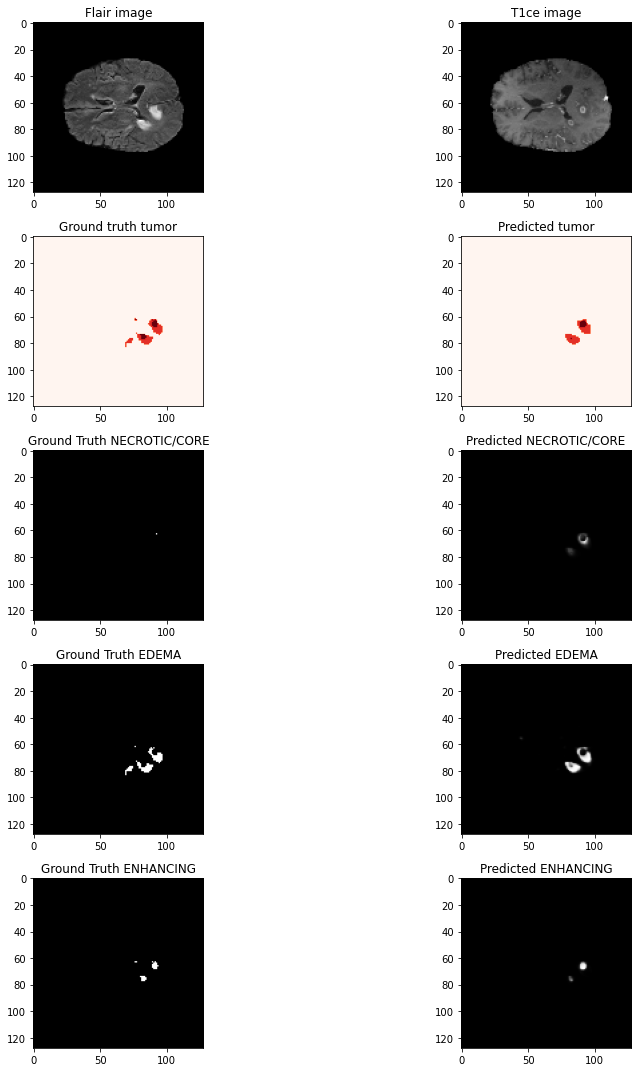

In [21]:
verify(idx=np.random.randint(len(testloader)), loader=testloader)

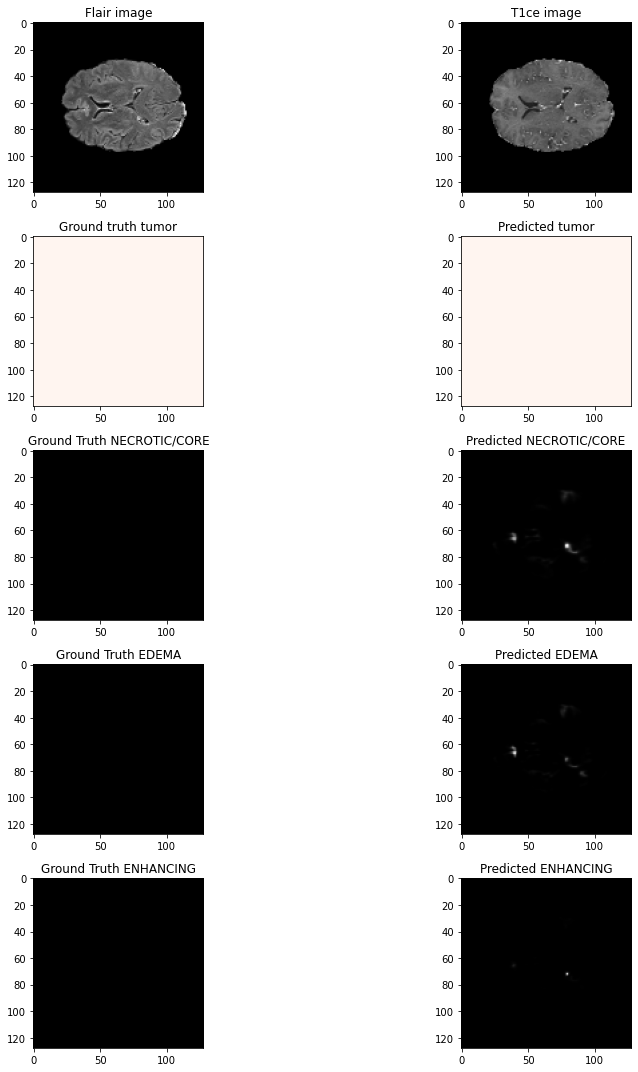

In [22]:
verify(idx=np.random.randint(len(testloader)), loader=testloader)

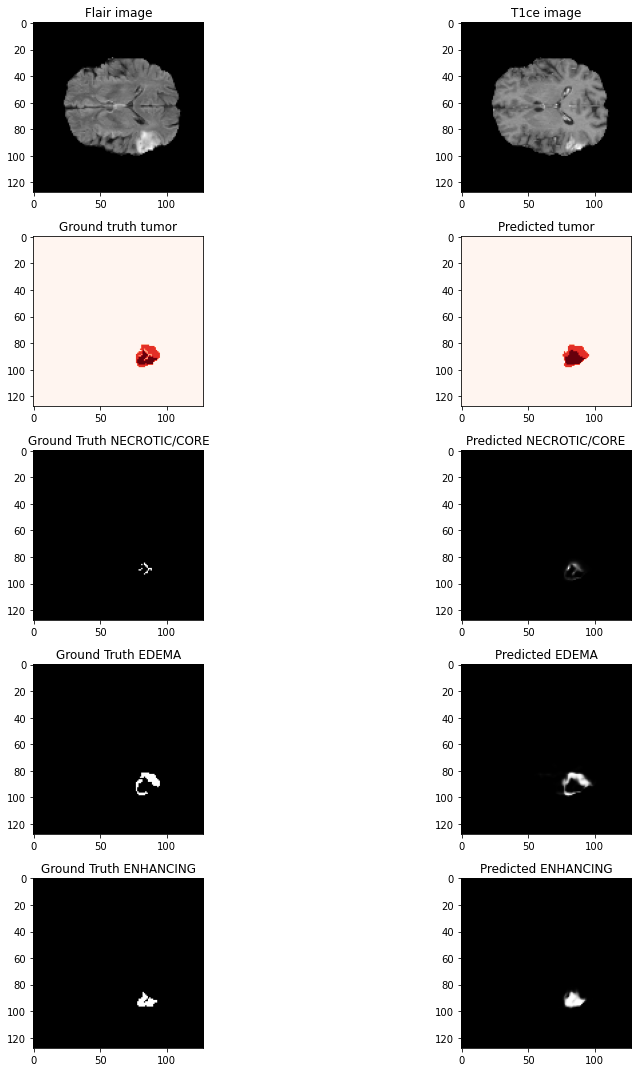

In [24]:
verify(idx=np.random.randint(len(testloader)), loader=testloader)

In [22]:
# save the entire best model
model.save("unet_brats.h5") 